In [6]:
import numpy as np
datall = np.load('./TexasData/datall_Texas.npy')
polall = np.load('./TexasData/polall_Texas.npy')

In [7]:
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from tensorflow.keras.layers import Bidirectional, concatenate, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import CSVLogger
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from tensorflow.python.keras.layers import Layer, InputSpec
import tensorflow as tf
tf.compat.v1.reset_default_graph()
from sklearn.metrics import accuracy_score

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten, Reshape, multiply
from keras.layers import concatenate, GRU, Input, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model
from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.models import Model



In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        #x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
drop_rate = 0.2
stochastic_depth_rate = 0.1

w1 = 100

positional_emb = False
conv_layers = 2
num_classes = 1
input_shape = (600,1)
image_size = 600  # We'll resize input images to this size
projection_dim = int(2*w1)
num_heads = 4
transformer_units = [
    projection_dim,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4

In [11]:
import tensorflow as tf
class CCTTokenizer1(layers.Layer):
    def __init__(
        self,
        kernel_size=4,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=(2,2,2,2,2,2,2,2),
        num_conv_layers=conv_layers,
        num_output_channels=[int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim)],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer1, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = tf.keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv1D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="same",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            #self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool1D(pooling_kernel_size, (pooling_stride[i]), "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, 1))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = dummy_outputs.shape[1]
            projection_dim = dummy_outputs.shape[-1]

            print(dummy_outputs,sequence_length,projection_dim)
            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [12]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [13]:
#def create_vit_classifier(inputs):
def create_cct_model1(inputs):


    # Augment data.
    #augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer1()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)

        #print(encoded_patches)
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        #x3 = x2
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)

        # Skip connection 2.
        #print(x3)
        x3 = StochasticDepth(dpr[i])(x3)
        #print(x3)
        encoded_patches = layers.Add()([x3, x2])
     
    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    
    ''' 
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)
    '''
    return representation

In [14]:
inputs = layers.Input(shape=input_shape,name='input')

featuresP = create_cct_model1(inputs)
#featuresP = layers.Dropout(0.2)(featuresP)
featuresP = layers.Flatten()(featuresP)
logitp = layers.Dense(1, activation='sigmoid')(featuresP)


#logitp  = Conv2D(1,  3, strides =(1), padding='same',activation='sigmoid', kernel_initializer='he_normal',name='picker_P')(featuresP)


model = Model(inputs=[inputs], outputs=[logitp])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 600, 1)]     0           []                               
                                                                                                  
 cct_tokenizer1 (CCTTokenizer1)  (None, 150, 200)    160800      ['input[0][0]']                  
                                                                                                  
 layer_normalization (LayerNorm  (None, 150, 200)    400         ['cct_tokenizer1[0][0]']         
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 150, 200)    642600      ['layer_normalization[0][0]',

                                                                                                  
 dense_5 (Dense)                (None, 150, 200)     40200       ['dropout_7[0][0]']              
                                                                                                  
 dropout_8 (Dropout)            (None, 150, 200)     0           ['dense_5[0][0]']                
                                                                                                  
 stochastic_depth_5 (Stochastic  (None, 150, 200)    0           ['dropout_8[0][0]']              
 Depth)                                                                                           
                                                                                                  
 add_5 (Add)                    (None, 150, 200)     0           ['stochastic_depth_5[0][0]',     
                                                                  'add_4[0][0]']                  
          

In [15]:
inputs = layers.Input(shape=input_shape,name='input')

featuresP = create_cct_model1(inputs)
featuresP = layers.Flatten()(featuresP)
featuresP = layers.Dropout(0.2)(featuresP)
logitp = layers.Dense(1, activation='sigmoid')(featuresP)


#logitp  = Conv2D(1,  3, strides =(1), padding='same',activation='sigmoid', kernel_initializer='he_normal',name='picker_P')(featuresP)


model = Model(inputs=[inputs], outputs=[logitp])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 600, 1)]     0           []                               
                                                                                                  
 cct_tokenizer1_1 (CCTTokenizer  (None, 150, 200)    160800      ['input[0][0]']                  
 1)                                                                                               
                                                                                                  
 layer_normalization_9 (LayerNo  (None, 150, 200)    400         ['cct_tokenizer1_1[0][0]']       
 rmalization)                                                                                     
                                                                                            

 dropout_19 (Dropout)           (None, 150, 200)     0           ['dense_13[0][0]']               
                                                                                                  
 dense_14 (Dense)               (None, 150, 200)     40200       ['dropout_19[0][0]']             
                                                                                                  
 dropout_20 (Dropout)           (None, 150, 200)     0           ['dense_14[0][0]']               
                                                                                                  
 stochastic_depth_13 (Stochasti  (None, 150, 200)    0           ['dropout_20[0][0]']             
 cDepth)                                                                                          
                                                                                                  
 add_13 (Add)                   (None, 150, 200)     0           ['stochastic_depth_13[0][0]',    
          

In [16]:
model.load_weights('best_weigths_Binary_CSCN_Best.h5')


2022-10-30 01:57:45.466878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 01:57:46.046360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9214 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5
2022-10-30 01:57:46.122432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


out = model.predict(datall,batch_size=1024, verbose=1)

/root/anaconda3/envs/tf-gpu-39/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-10-30 01:57:47.642029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-10-30 01:57:48.283896: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-10-30 01:57:48.355355: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#outtest = np.argmax(out,axis=-1)
thre = 0.5
outtest = out
outtest[outtest<thre]=0
outtest[outtest>=thre]=1
labtest = polall

accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='micro'),recall_score(labtest,outtest, average='micro'),f1_score(labtest,outtest, average='micro')

(0.94590948651000872,
 0.94590948651000872,
 0.94590948651000872,
 0.94590948651000872)

In [19]:
accuracy_score(labtest,outtest),precision_score(labtest,outtest, average=None),recall_score(labtest,outtest, average=None),f1_score(labtest,outtest, average=None)

(0.94590948651000872,
 array([ 0.97869277,  0.89579665]),
 array([ 0.93488276,  0.96491644]),
 array([ 0.95628627,  0.92907275]))

In [20]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(labtest, outtest)

print(cf_matrix)

[[13596   947]
 [  296  8141]]


<AxesSubplot:>

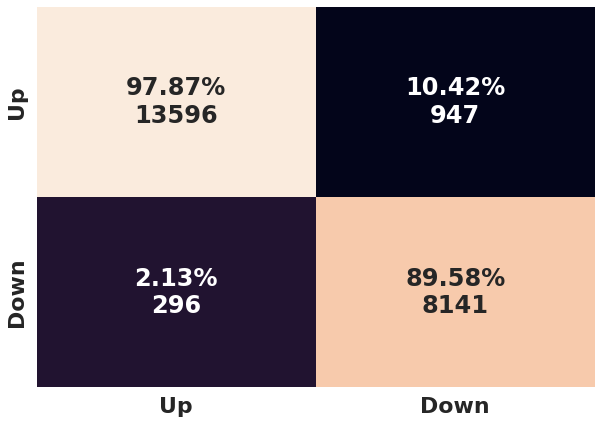

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

cf = cf_matrix
categories=['Up','Down']
group_percentages = []
counts = []
for i in range(len(cf)):
    for j in range(len(cf)):
        group_percentages.append(cf[j, i]/np.sum(cf[:, i]))
        counts.append(cf[j, i])

percentages_matrix = np.reshape(group_percentages, (2, 2))
group_percentages = ['{0:.2%}'.format(value) for value in group_percentages]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, counts)]
labels = np.asarray(labels).reshape(2, 2, order = 'F')

fig = plt.figure(figsize=(10,7))
sn.set(font_scale=2) # for label size
sn.heatmap(percentages_matrix, annot = labels, fmt = '', xticklabels=categories, yticklabels = categories, cbar = False)
#fig.savefig('Conf_Matrix',bbox_inches='tight',transparent=True, dpi =100)


In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


checkpoint = ModelCheckpoint(filepath='best_weigths_Binary_Texas_Transfer10.h5',
                             monitor='val_acc',
                             mode = 'max',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=0.1,
                                   cooldown=0,
                                   patience=50,
                                   min_lr=0.5e-6,
                                   monitor='val_acc',
                                   mode = 'max',
                                  verbose= 1)

In [23]:
import numpy as np
ind = np.random.permutation(len(datall))
a = int(10*len(ind)/100)
ind = ind[0:a]
x = datall[ind]
y = polall[ind]

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=['binary_crossentropy'], metrics=['acc'])
model.load_weights('best_weigths_Binary_CSCN_Best.h5')

model.fit(x, y, batch_size=128, epochs=50, verbose =1, validation_split=0.1, shuffle=True, callbacks=[checkpoint,lr_reducer])

Train on 2068 samples, validate on 230 samples
Epoch 1/50
2068/2068 [==============================] - ETA: 0s - loss: 0.0928 - acc: 0.9671

/root/anaconda3/envs/tf-gpu-39/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_acc improved from -inf to 0.96957, saving model to best_weigths_Binary_Texas_Transfer10.h5
2068/2068 [==============================] - 5s 2ms/sample - loss: 0.0928 - acc: 0.9671 - val_loss: 0.0449 - val_acc: 0.9696 - lr: 0.0010
Epoch 2/50
2048/2068 [============================>.] - ETA: 0s - loss: 0.0523 - acc: 0.9858
Epoch 2: val_acc did not improve from 0.96957
2068/2068 [==============================] - 2s 1ms/sample - loss: 0.0520 - acc: 0.9860 - val_loss: 0.0527 - val_acc: 0.9696 - lr: 0.0010
Epoch 3/50
2048/2068 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9907
Epoch 3: val_acc improved from 0.96957 to 0.97826, saving model to best_weigths_Binary_Texas_Transfer10.h5
2068/2068 [==============================] - 2s 1ms/sample - loss: 0.0445 - acc: 0.9903 - val_loss: 0.0538 - val_acc: 0.9783 - lr: 0.0010
Epoch 4/50
2048/2068 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9927
Epoch 4: val_acc did not improve from 0.97826
206

Epoch 30/50
2048/2068 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9995
Epoch 30: val_acc did not improve from 0.98696
2068/2068 [==============================] - 2s 1ms/sample - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0707 - val_acc: 0.9826 - lr: 0.0010
Epoch 31/50
2048/2068 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 1.0000
Epoch 31: val_acc did not improve from 0.98696
2068/2068 [==============================] - 2s 1ms/sample - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0711 - val_acc: 0.9870 - lr: 0.0010
Epoch 32/50
2048/2068 [============================>.] - ETA: 0s - loss: 8.4120e-04 - acc: 0.9995
Epoch 32: val_acc did not improve from 0.98696
2068/2068 [==============================] - 2s 1ms/sample - loss: 8.3401e-04 - acc: 0.9995 - val_loss: 0.0946 - val_acc: 0.9783 - lr: 0.0010
Epoch 33/50
2048/2068 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9985
Epoch 33: val_acc did not improve from 0.98696
2068/2068 [===

In [24]:
model.load_weights('best_weigths_Binary_Texas_Transfer10.h5')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


out = model.predict(datall,batch_size=1024, verbose=1)

/root/anaconda3/envs/tf-gpu-39/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#outtest = np.argmax(out,axis=-1)
thre = 0.5
outtest = out
outtest[outtest<thre]=0
outtest[outtest>=thre]=1
labtest = polall

accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='micro'),recall_score(labtest,outtest, average='micro'),f1_score(labtest,outtest, average='micro')

(0.98572671888598784,
 0.98572671888598784,
 0.98572671888598784,
 0.98572671888598784)

In [26]:
accuracy_score(labtest,outtest),precision_score(labtest,outtest, average=None),recall_score(labtest,outtest, average=None),f1_score(labtest,outtest, average=None)

(0.98572671888598784,
 array([ 0.98912669,  0.97987928]),
 array([ 0.98831053,  0.98127296]),
 array([ 0.98871844,  0.98057562]))

In [27]:
accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='macro'),recall_score(labtest,outtest, average='macro'),f1_score(labtest,outtest, average='macro')

(0.98572671888598784,
 0.98450298515336732,
 0.98479174586265539,
 0.98464703368634043)